# 東レ 日足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '3402.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1y')
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-27 00:00:00+09:00,995.599976,1007.000000,987.700012,996.0,6361600,0.0,0.0
2025-02-28 00:00:00+09:00,987.000000,997.799988,975.200012,996.0,8848600,0.0,0.0
2025-03-03 00:00:00+09:00,1011.000000,1020.000000,1000.500000,1008.0,5763900,0.0,0.0
2025-03-04 00:00:00+09:00,1010.000000,1027.000000,1006.500000,1024.5,9869800,0.0,0.0
2025-03-05 00:00:00+09:00,1030.500000,1060.000000,1025.000000,1060.0,7040200,0.0,0.0


## 日足チャートとパラボリック SAR

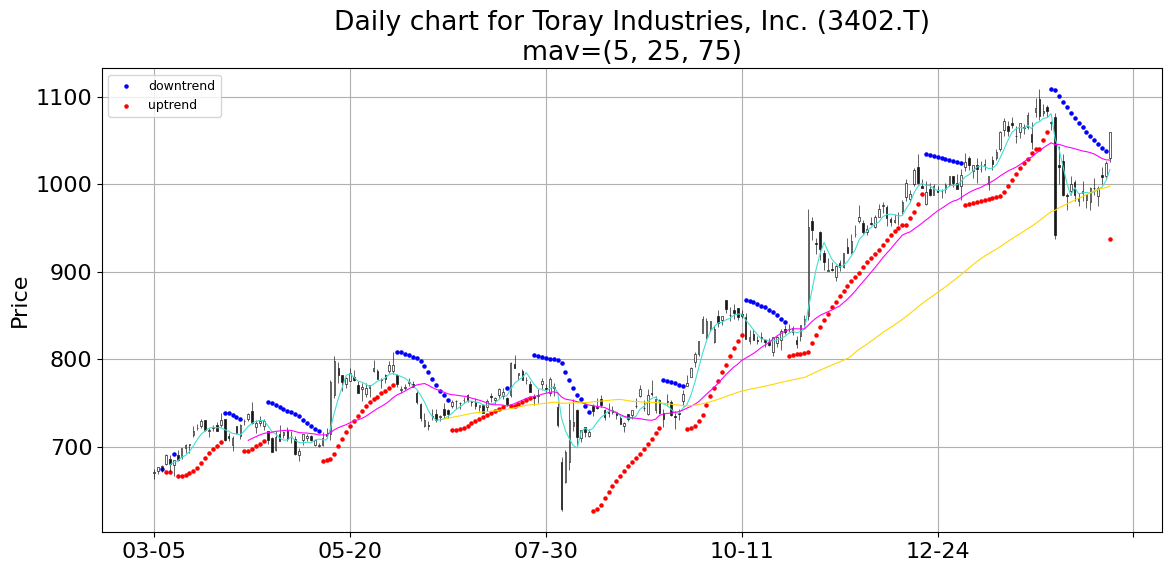

In [3]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
ax.legend(loc='best', fontsize=9)


plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [14]:
df.tail(2)['Close']

Date
2025-02-12 00:00:00+09:00     941.700012
2025-02-13 00:00:00+09:00    1023.500000
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-02-04 00:00:00+09:00    NaN
2025-02-05 00:00:00+09:00   -9.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-02-04 00:00:00+09:00    1069.9
2025-02-05 00:00:00+09:00    1071.5
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-02-04 00:00:00+09:00    1034.876001
2025-02-05 00:00:00+09:00    1038.284001
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-02-04 00:00:00+09:00    955.092001
2025-02-05 00:00:00+09:00    958.493334
Name: Close, dtype: float64